### Titanic Dataset - Asimetría de las variables numéricas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Cargar dataset
df = pd.read_csv("Titanic-Dataset.csv")
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print("Columnas del dataset:\n", df.columns)
print("\nTipos de datos:\n", df.dtypes)

Columnas del dataset:
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Tipos de datos:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [20]:
numericas_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categoricas_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numericas_cols)
print("Categóricas:", categoricas_cols)


Numéricas: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categóricas: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [ ]:
from statistics import harmonic_mean, geometric_mean
from collections import Counter

def moda(s: pd.Series):
    nulos = s.dropna().tolist()
    if not nulos:
        return np.nan
    c = Counter(nulos)
    maxf = max(c.values())
    modas = [v for v, f in c.items() if f == maxf]
    # si todas ocurren una vez, no hay moda
    if maxf == 1:
        return np.nan
    try:
        return min(modas)  # modo más pequeño si hay empate
    except:
        return modas[0]

def medidas_tendencia(s: pd.Series):
    s = pd.to_numeric(s, errors='coerce').dropna()
    salida = {}
    if len(s) == 0:
        return {"media":np.nan,"mediana":np.nan, "moda":np.nan, "harmonica":np.nan,"geometrica":np.nan}
    salida["media"] = s.mean()
    positivos = s[s > 0]
    salida["mediana"] = s.median()
    salida["moda"] = moda(s)
    salida["harmonica"] = harmonic_mean(positivos) if len(positivos) > 0 else np.nan
    salida["geometrica"] = geometric_mean(positivos) if len(positivos) > 0 else np.nan
    return salida

tendencias = {col: medidas_tendencia(df[col]) for col in numericas_cols}
pd.DataFrame(tendencias).T


,media,mediana,moda,harmonica,geometrica
PassengerId,446.000000,446.0000,NaN,120.893535,329.371907
Survived,0.383838,0.0000,0.00,1.000000,1.000000
Pclass,2.308642,3.0000,3.00,1.889046,2.113932
Age,29.699118,28.0000,24.00,13.408574,24.429880
SibSp,0.523008,0.0000,0.00,1.205752,1.348155
Parch,0.381594,0.0000,0.00,1.316169,1.430969
Fare,32.204208,14.4542,8.05,13.681705,18.980239


Al revisar las medidas de tendencia central se observa que la columna *PassengerId* no presenta moda, lo que confirma que es un identificador único y sin relevancia estadística. En *Survived*, la media refleja que poco menos del 40% de los pasajeros sobrevivió, mientras que la mediana y la moda coinciden en 0, lo que indica que la mayoría no lo logró. Para *Pclass*, tanto la mediana como la moda señalan la tercera clase como la más común, lo que concuerda con la media situada entre segunda y tercera. En *Age*, la media resulta algo mayor que la mediana, lo que muestra un ligero sesgo hacia edades más altas; la moda en 24 años indica que era frecuente encontrar jóvenes adultos. Las variables *SibSp* y *Parch* muestran medias bajas y moda igual a cero, lo que confirma que la mayoría de los pasajeros viajaba sin familiares cercanos. Finalmente, en *Fare* se nota un fuerte sesgo positivo: la media es mucho mayor que la mediana, lo que implica que unos pocos valores muy altos elevan el promedio; la moda en 8.05 corresponde a la tarifa más repetida.


Podemos revisar si hay alguna aproximación gaussiana en las variables a través del sesgo. Veamos

In [ ]:
from scipy.stats import skew

def calcular_sesgo(serie: pd.Series):
    x = pd.to_numeric(serie, errors='coerce').dropna()
    if len(x) < 3:
        return {"coef_fisher": np.nan, "interpretacion": "indeterminado"}
    g1 = skew(x, bias=False)
    if abs(g1) < 0.5:
        interpretacion = "aprox. simétrica (cercana a gaussiana)"
    elif g1 > 0:
        interpretacion = "sesgo positivo"
    else:
        interpretacion = "sesgo negativo"
    
    return {"coef_fisher": g1, "interpretacion": interpretacion}

columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

resultados_sesgo = {col: calcular_sesgo(df[col]) for col in columnas_numericas}

pd.DataFrame(resultados_sesgo).T

,coef_fisher,interpretacion
PassengerId,0.0,aprox. simétrica (cercana a gaussiana)
Survived,0.478523,aprox. simétrica (cercana a gaussiana)
Pclass,-0.630548,sesgo negativo (cola izquierda)
Age,0.389108,aprox. simétrica (cercana a gaussiana)
SibSp,3.695352,sesgo positivo (cola derecha)
Parch,2.749117,sesgo positivo (cola derecha)
Fare,4.787317,sesgo positivo (cola derecha)


Ahora de manera visual tenemos:

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


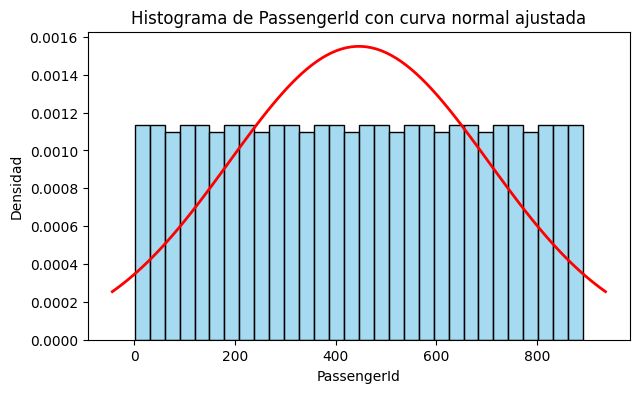

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


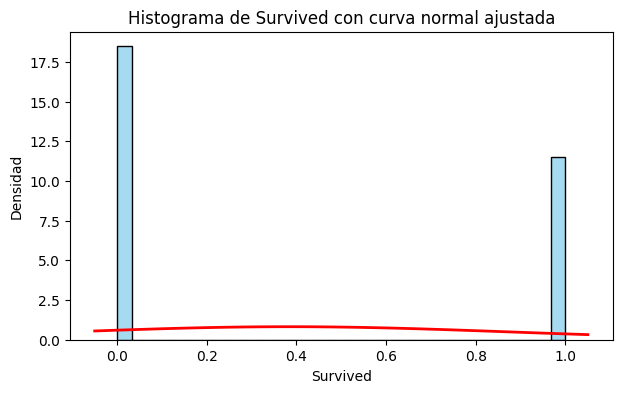

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


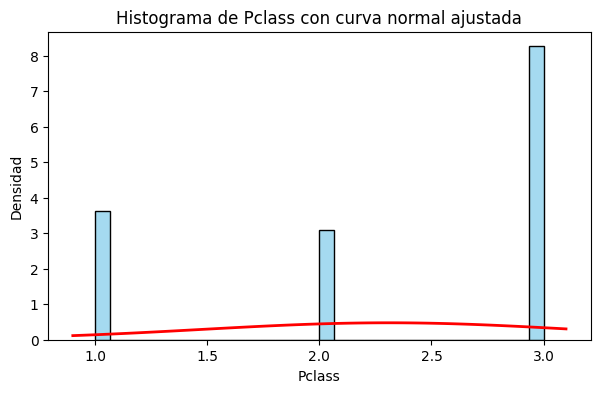

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


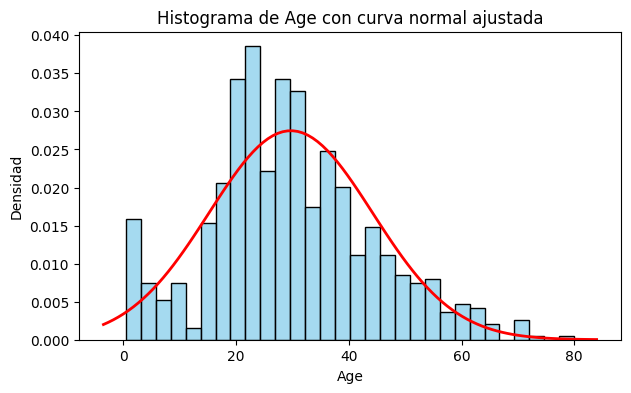

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


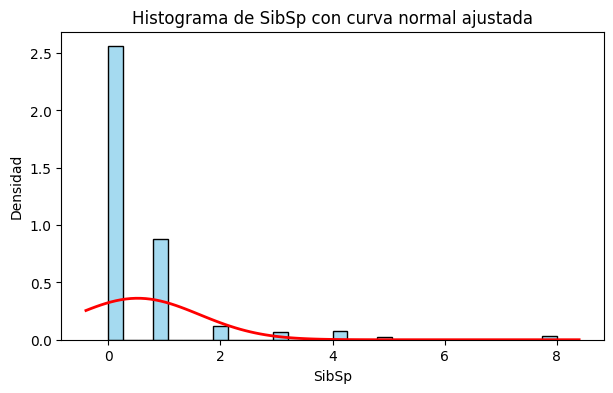

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


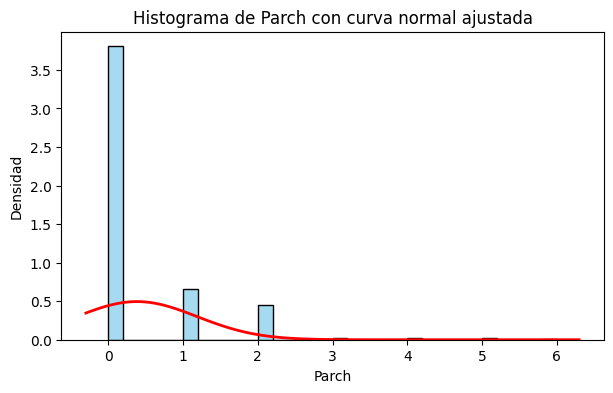

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


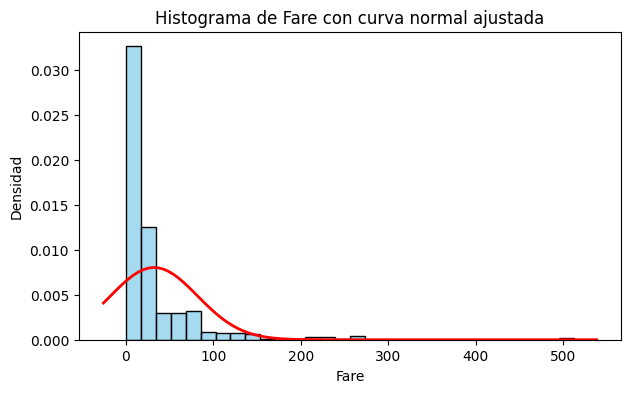

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

def histograma_con_normal(variable, nombre):
    x = pd.to_numeric(df[variable], errors='coerce').dropna()
    plt.figure(figsize=(7,4))
    sns.histplot(x, bins=30, kde=False, color="skyblue", stat="density")
    mu, sigma = x.mean(), x.std()
    xmin, xmax = plt.xlim()
    valores = np.linspace(xmin, xmax, 100)
    pdf = norm.pdf(valores, mu, sigma)
    plt.plot(valores, pdf, 'r', linewidth=2)
    
    plt.title(f"Histograma de {nombre} con curva normal ajustada")
    plt.xlabel(nombre)
    plt.ylabel("Densidad")
    plt.show()

for col in numericas_cols:
    histograma_con_normal(col, col)


Al analizar los histogramas con la curva normal ajustada se observa que la variable PassengerId presenta un comportamiento completamente uniforme, ya que corresponde a un identificador consecutivo y no a una característica de los pasajeros. Por ello, la superposición de la curva normal no resulta adecuada y esta variable debería excluirse de los análisis estadísticos. En el caso de Survived, el histograma muestra únicamente dos barras, correspondientes a los valores 0 y 1. Esto refleja la naturaleza binaria de la variable y confirma que no tiene sentido aproximarla a una distribución gaussiana ni hablar de sesgo en este contexto. Algo similar ocurre con Pclass: al ser discreta y con solo tres categorías posibles (1ª, 2ª y 3ª clase), su histograma tampoco puede considerarse normal. La mayor concentración de pasajeros en tercera clase genera una asimetría evidente hacia ese valor. La variable Age presenta un histograma que se asemeja más a una curva normal, aunque con ciertas desviaciones. La media se encuentra ligeramente desplazada hacia valores superiores en comparación con la mediana, lo que sugiere un sesgo positivo leve hacia edades mayores. En contraste, las variables SibSp y Parch muestran una gran concentración en cero, reflejando que la mayoría de los pasajeros viajaban sin familiares directos. Esto genera histogramas con una barra predominante en cero y colas largas hacia la derecha, lo que indica un sesgo positivo marcado. Finalmente, la variable Fare también presenta un fuerte sesgo positivo. La mayoría de los boletos tenían precios bajos, pero existen algunos pocos extremadamente caros que alargan la cola derecha de la distribución y elevan la media muy por encima de la mediana.  

Entre todas las variables numéricas únicamente Age presenta un comportamiento que podría aproximarse parcialmente a una distribución normal. Las demás muestran asimetrías claras o son variables discretas en las que el análisis de normalidad no resulta apropiado.


In [26]:
def dispersion(serie: pd.Series):
    x = pd.to_numeric(serie, errors='coerce').dropna()
    if len(x) == 0:
        return {"varianza": np.nan, "desv_estandar": np.nan, "desv_media": np.nan}
    
    media = x.mean()
    varianza = x.var(ddof=1)                # varianza muestral
    desv_estandar = x.std(ddof=1)           # desviación estándar
    desv_media = (x - media).abs().mean()   # desviación media respecto a la media
    
    return {"varianza": varianza, "desv_estandar": desv_estandar, "desv_media": desv_media}

resultados_dispersion = {col: dispersion(df[col]) for col in columnas_numericas}

pd.DataFrame(resultados_dispersion).T


,varianza,desv_estandar,desv_media
PassengerId,66231.000000,257.353842,222.749719
Survived,0.236772,0.486592,0.473013
Pclass,0.699015,0.836071,0.761968
Age,211.019125,14.526497,11.322944
SibSp,1.216043,1.102743,0.713780
Parch,0.649728,0.806057,0.580742
Fare,2469.436846,49.693429,28.163692


In [ ]:
def asimetria(serie: pd.Series):
    x = pd.to_numeric(serie, errors='coerce').dropna()
    
    if len(x) < 3:
        return {"fisher": np.nan, "pearson": np.nan}
    
    media = x.mean()
    mediana = x.median()
    desv_estandar = x.std(ddof=1)
    
    # Coeficiente de Fisher. Ya calculado antes
    fisher = skew(x, bias=False)
    
    # Coeficiente de Pearson
    pearson = (3 * (media - mediana)) / desv_estandar if desv_estandar > 0 else np.nan
    
    return {"fisher": fisher, "pearson": pearson}

resultados_asimetria = {col: asimetria(df[col]) for col in columnas_numericas}

pd.DataFrame(resultados_asimetria).T


,fisher,pearson
PassengerId,0.000000,0.000000
Survived,0.478523,2.366488
Pclass,-0.630548,-2.480738
Age,0.389108,0.350900
SibSp,3.695352,1.422836
Parch,2.749117,1.420223
Fare,4.787317,1.071571
